# Проект Danss
В данном проекте определяются поправки к зависимости осциляций нетрино от пройденого пути вызваные не точечностью источника частиц и детектора.



## Задача
Определить распределение электроного и мюоного нейтрино в детекторе расположеного возле реактора.


## Геометрия задачи
Рассмотрим следующию модель:реактор - цилиндр с высотой H и радиусом R

*   реактор - цилиндр с высотой $H$ и радиусом $R$
*   детектор - куб с длиной ребра $a$
*   Взаимное расположение: куб и цилиндр стоят на одной плоскости. $L$ - растояие между центрами фигур, $\theta$ - угол поворота куба в этой плоскости
(т.е. угл между прямой соединяющей центры фигур и нормалью грани)

Если мы будим использовать декардовы координаты от центра основания для точки из детектора ($x, y, z$) и цилиндрические координаты для точки из реактора ($h, r, \varphi$), то растояние между точкой из реактора и точкой из детектора будет:

$ l=\sqrt{(L-r\cos \varphi -y\cos θ +x\sin θ)^2 + (r\sin \varphi +y\sin θ +x\cos θ)^2 +(z-h)^2}$

Распределение растояний будет тогда:

$$ F(l) = \frac{\int_{l(...)=l}{dxdydzdhdrdφ}}{\int{dxdydzdhdrdφ}}=\frac{1}{\pi R^2Ha^3}\int_{l(...)=l}{dxdydzdhdrdφ}$$

Как видно, в явном виде посчитать этот интеграл не представляется возможным.

Для нахождения F(l) сделаем численый расчёт.

В эксперименте на Калининской АЭС геометрические параметры следующие:

$a=1\ \text{м},\ R=2\ \text{м},\ H=2\ \text{м},\ L=9-11\ \text{м}$

## Численый метод определения распределения
Код находится в "main.cpp"

### Метод прямого перебора

В методе прямого перебора мы создаём регулярную сетку точек в объёмах куба и цилиндра с неким шагом.

Главный недостаток даного метода связан с длительностью исполнения вложеных циклов при достаточно малого шага сетки (число пар растёт как $(\frac{\text{размеры тел}}{ϵ})^6 \sim 10^{3*6}$).

### Метод Монте-Карло
Для ускорения расчёта мы можем генерировать две случайые точки с равномерным распределением в объёмах детектора и реактора, а потом определять растоянием между ними. Таким образом мы пролучаем репрезентативную выборотку пар точек и соотвествующих длин.
Даный метод работает быстрее потому что достаточно сгенерировать выборотку длиной примерно $10^6$

Один из главных моментов в методе является правильный выбор распределения вероятностей в ГПСЧ. Наша цель сделать равномерно по объёму, т.е. т.е. для любого интегрирования плотности в. по равновеликим фигурам даёт одно и тоже значение вероятности.
Есть два варианта (по x,y,z,h вопросов нет):
*   равномерно по $φ$ и $r$, тогда в центре "плотнее"
*   равномерно по $φ$ и $\frac{r^2}{2}$ (так как $ds=rdr d\varphi$)

При втором варианте достигается требуемый вариант.


### Отрисовка распределения
Воспользуемся пакетами matplotlib

In [1]:
import numpy as np
#Рисование (Импорт)
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
#Получение данных гистограммы

data=[]
with open('Data_mont', 'r') as file:
    arr=file.readlines()
    for line in arr[9:]:
        data.append(int(line))
    # arrx, arrx, arrz = arr[1].split()
    # H = float(arrz)
    # arrx, arrx, arrz = arr[2].split()
    # R = float(arrz)
    # arrx, arrx, arrz = arr[3].split()
    # a = float(arrz)
    # arrx, arrx, arrz = arr[4].split()
    # L = float(arrz)
    # arrx, arrx, arrz = arr[5].split()
    # theta = float(arrz)
    arrx, arrx, arrx, arry, arrz = arr[6].split()
    x_max = float(arry)
    x_min = float(arrz)
    arrx, arrx, arrz = arr[7].split()
    err = float(arrz)

# data = np.loadtxt('Data_end', skiprows = 1)
# x_min =
# err =

In [3]:
#Обработка (добавление длин)
l=[]
for i in range(len(data)):
    l.append(x_min+ i*err)

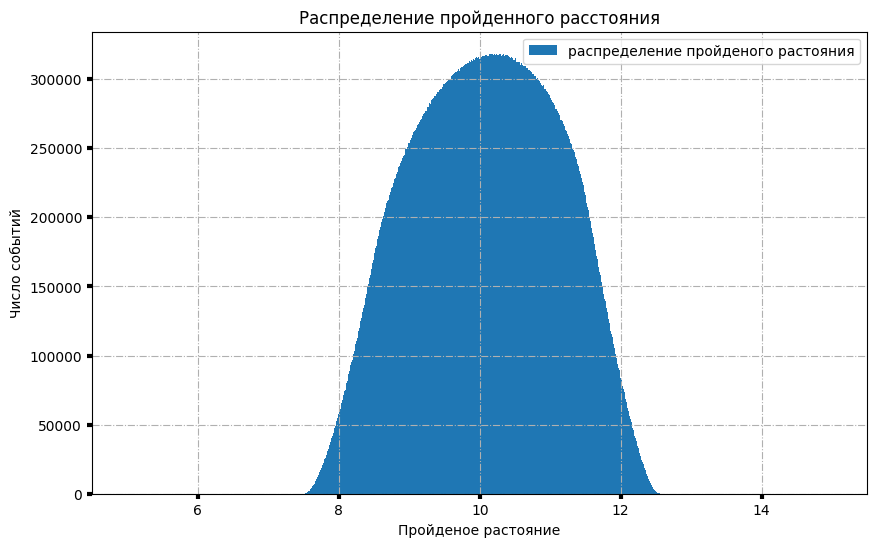

In [4]:
#Рисование гистограммы и другое
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Распределение пройденного расстояния')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")

ax.legend()
pyplot.show()

## Фитирование распределения $F(l)$

Воспользуемся пакетами scipy.optimize для фитирования полученной гистограммы.

### Поиск пробной функции

In [5]:
#Фитирование (библиотеки)
from scipy.optimize import curve_fit
from scipy.special import  erf
from math import exp

In [6]:
# Границы фитирования
flag = 0;
for i in range(len(data)):
  if flag == 0 and data[i]>0:
    i_min = i
    flag = 1
  if flag == 1 and data[i] ==0:
    i_max=i
    break

In [7]:
#Пробная функция - квадратичная
def parab(x, a, b, c):
    return c-a*np.power(np.abs(x-b), 2)
args_p, covar_p = curve_fit(parab, l[i_min+100:i_max-100], data[i_min+100:i_max-100], [1.,10.0, 400.0])
perr = np.sqrt(np.diag(covar_p))
args_p, perr

(array([5.32367837e+04, 1.01367907e+01, 3.20550037e+05]),
 array([3.46594029e+02, 2.68015978e-03, 3.81261353e+02]))

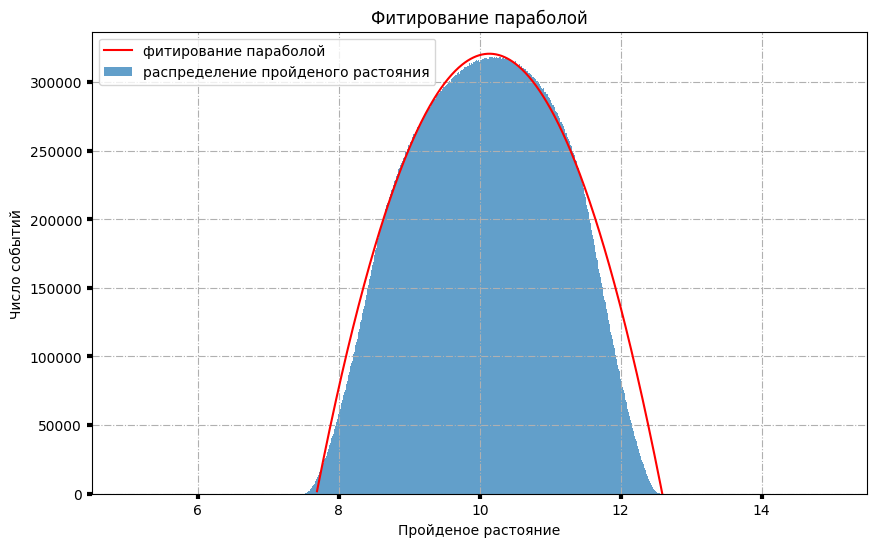

In [8]:
x = []
y = []
for i in range(len(l)):
    if parab(l[i], args_p[0], args_p[1], args_p[2]) > 0:
      x.append(l[i])
      y.append(parab(l[i], args_p[0], args_p[1], args_p[2]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование параболой')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l, data, linewidth = 1., width = err, alpha = 0.7, label = "распределение пройденого растояния")
ax.plot(x, y, color='r', label = "фитирование параболой")
ax.legend()
pyplot.show()

In [9]:
#Фитирование гаусовым пиком
def gauss(x, a, b, c, d):
    return a*np.exp(-(x-b)**2 /c)+d
args, covar = curve_fit(gauss, l[i_min:i_max], data[i_min:i_max], [300000.0,11.0, 100.0,0.0])
perr = np.sqrt(np.diag(covar))
args, perr

(array([-4.40809055e+09,  1.00788519e+01, -7.78368689e+04,  4.40840980e+09]),
 array([5.33400342e+10, 3.90070966e-03, 9.41828703e+05, 5.33400344e+10]))

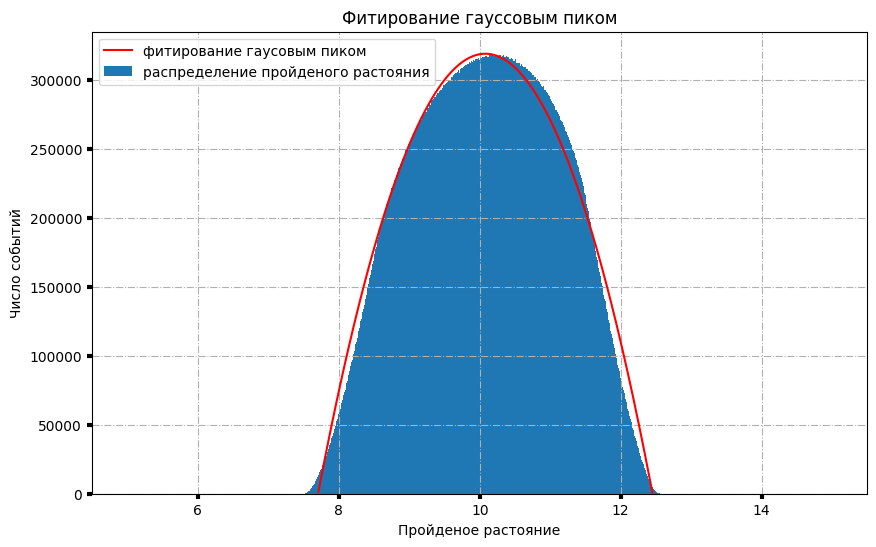

In [10]:
xx = []
yy = []
for i in range(i_min, i_max):
    if gauss(l[i], args[0], args[1], args[2], args[3]) > 0:
      xx.append(l[i])
      yy.append(gauss(l[i], args[0], args[1], args[2], args[3]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование гауссовым пиком')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(xx, yy, color='r', label = "фитирование гаусовым пиком")
ax.legend()
pyplot.show()

In [40]:
#Фитирование гаусовым пиком
def gauss_as(x, a, b, c, d, f):
    return a* np.exp(-(x-b)**2/c)*(1+erf(f*x))+d
    # a*np.exp(-(x-b)**2 /c1)+d
args, covar = curve_fit(gauss_as, l[i_min:i_max], data[i_min:i_max], [300000.0,11.0, 100.0,0.0, -0.01])
perr = np.sqrt(np.diag(covar))
args, perr

(array([-1.58466682e+11,  1.01191043e+01, -5.23740403e+06,  3.16933687e+11,
         4.72328561e-01]),
 array([2.30873477e+10, 3.78767467e-03, 7.63294291e+05, 4.61746953e+10,
        2.78549712e-03]))

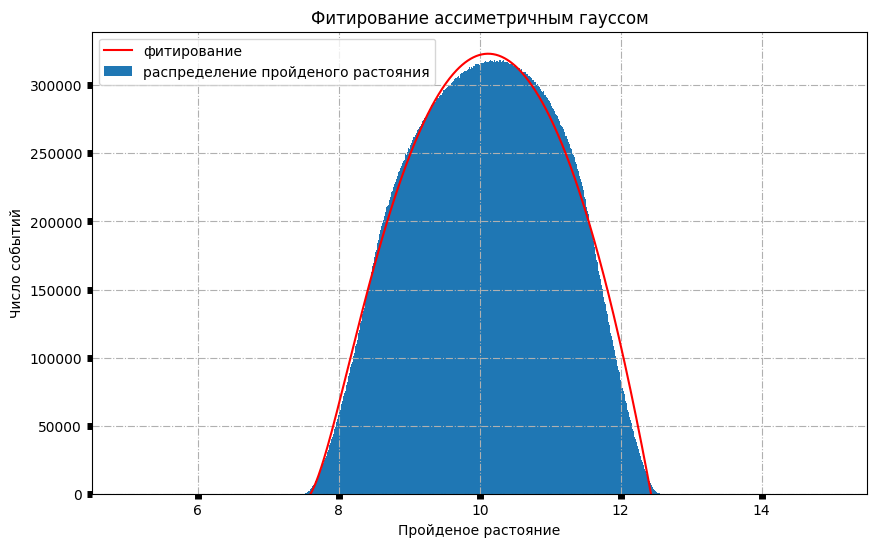

In [42]:
xxx = []
yyy = []
for i in range(i_min, i_max):
    if gauss_as(l[i], args[0], args[1], args[2], args[3], args[4]) > 0:
      xxx.append(l[i])
      yyy.append(gauss_as(l[i], args[0], args[1], args[2], args[3], args[4]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование ассиметричным гауссом')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(xxx, yyy, color='r', label = "фитирование")
ax.legend()
pyplot.show()

In [37]:
#Фитирование гаусовым пиком
def gauss_log(x, a, b, c, d):
    return a/x* np.exp(-(np.log(x) + b)**2/c) + d
args, covar = curve_fit(gauss_log, l[i_min:i_max], data[i_min:i_max], [300000.0,-2.1, 1.0, 0.0])
perr = np.sqrt(np.diag(covar))
args, perr

(array([ 6.31186029e+06, -2.33619356e+00,  8.20080651e-02, -2.93341399e+05]),
 array([3.59140692e+05, 3.18325784e-03, 6.53857498e-03, 3.54260622e+04]))

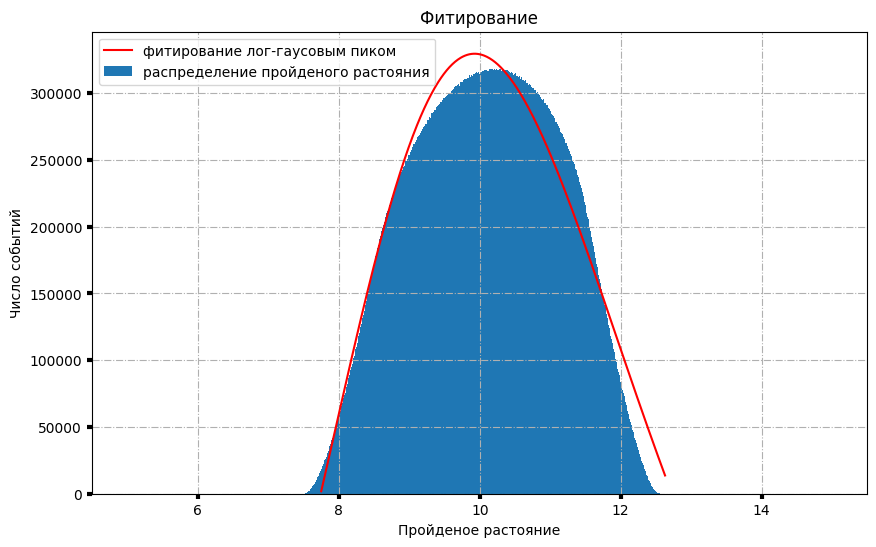

In [38]:
xx = []
yy = []
for i in range(i_min, i_max):
    if gauss_log(l[i], args[0], args[1], args[2], args[3]) > 0:
      xx.append(l[i])
      yy.append(gauss_log(l[i], args[0], args[1], args[2], args[3]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(xx, yy, color='r', label = "фитирование лог-гаусовым пиком")
ax.legend()
pyplot.show()

In [74]:
#Фитирование полиномом
def pol_12(x, a, b, c, d, f, g, h,k,l,m, n, o, p):
    return a+b*x+c*x**2+d*x**3+f*x**4+g*x**5+h*x**6+k*x**7+l*x**8+m*x**9+n*x**10+o*x**11+p*x**12
def pol_6(x, a, b, c, d, f, g, h):
    return a+b*x+c*x**2+d*x**3+f*x**4+g*x**5+h*x**6
def pol_3(x, a, b, c, d):
    return a+b*x+c*x**2+d*x**3

args_12, covar_12 = curve_fit(pol_12, l[i_min:i_max], data[i_min:i_max])
perr_12 = np.sqrt(np.diag(covar_12))
print(args_12, perr_12)
args_6, covar_6 = curve_fit(pol_6, l[i_min:i_max], data[i_min:i_max], [1.0,1., 1.0, 1.0, 1.0, 1.0, 1.0])
perr_6 = np.sqrt(np.diag(covar_6))
print(args_6, perr_6)
args_3, covar_3 = curve_fit(pol_3, l[i_min:i_max], data[i_min:i_max], [1.0,1., 1.0, 1.0])
perr_3 = np.sqrt(np.diag(covar_3))
print(args_3, perr_3)

[-6.58870407e+02  5.98716683e+01  7.49011661e+00  5.48489095e-03
  3.84163850e+03 -6.66093611e+00 -9.54425899e+00 -1.39407754e-01
 -2.65863272e+01  7.59894053e-02  3.68928141e+00 -1.04030332e+00
  1.33428740e-01 -9.20116955e-03  3.32346963e-04 -4.95807783e-06] [8.03985072e+02 7.26670133e+01 1.61305618e+00 6.46212068e-02
 8.90477888e+01 8.35261045e-01 9.55931854e-01 1.66310095e-02
 5.63919767e-01 9.45944974e-03 7.60631943e-02 2.11192806e-02
 2.68616104e-03 1.84424707e-04 6.65212639e-06 9.93438349e-08]
[ 1.82134557e+09 -1.12235965e+09  2.86360962e+08 -3.87408279e+07
  2.93223970e+06 -1.17750885e+05  1.95998906e+03] [2.20867041e+07 1.35392253e+07 3.43832894e+06 4.63041401e+05
 3.48787755e+04 1.39341928e+03 2.30681227e+01]
[-3.64524929e+06  5.94031094e+05 -1.51016827e+03 -1.82561513e+03] [239255.67176178  72887.28479725   7316.11422791    242.07016118]


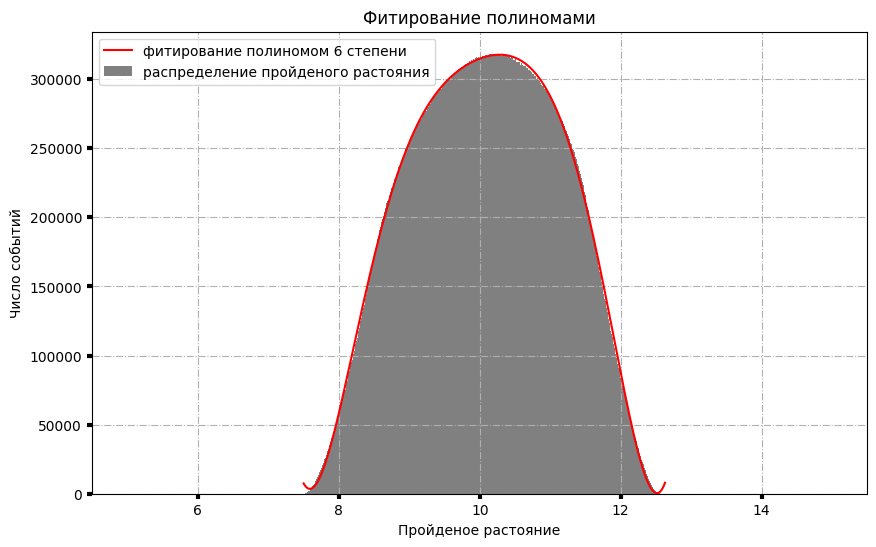

In [75]:
x12 = []
y12 = []
x6 = []
y6 = []
x3 = []
y3 = []
for i in range(i_min, i_max):
    if pol_12(l[i], args_12[0], args_12[1], args_12[2], args_12[3], args_12[4], args_12[5], args_12[6], args_12[7], args_12[8], args_12[9], args_12[10], args_12[11], args_12[12]) > 0:
      x12.append(l[i])
      y12.append(pol_12(l[i], args_12[0], args_12[1], args_12[2], args_12[3], args_12[4], args_12[5], args_12[6], args_12[7], args_12[8], args_12[9], args_12[10], args_12[11], args_12[12]))
    if pol_6(l[i], args_6[0], args_6[1], args_6[2], args_6[3], args_6[4], args_6[5], args_6[6]) > 0:
      x6.append(l[i])
      y6.append(pol_6(l[i], args_6[0], args_6[1], args_6[2], args_6[3], args_6[4], args_6[5], args_6[6]))
    if pol_3(l[i], args_3[0], args_3[1], args_3[2], args_3[3]) > 0:
      x3.append(l[i])
      y3.append(pol_3(l[i], args_3[0], args_3[1], args_3[2], args_3[3]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование полиномами')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., color='grey', width = err, label = "распределение пройденого растояния")
# ax.plot(x12, y12, color='g', label = "фитирование полиномом 12 степени")
ax.plot(x6, y6, color='r', label = "фитирование полиномом 6 степени")
# ax.plot(x3, y3, color='b', label = "фитирование полиномом 3 степени")
ax.legend()
pyplot.show()

111
<!-- ### Определение зависимости от параметров
Проделаем серию вычислений, для разных значений параметров задачи: $a, R, H, L, θ$

Для простоты фитирование вынесено в отдельный файл. -->